# Exercicios

1) Rode uma regressão linear para prever os preços das casas e inteprete os resultados dos betas.
Agora rode um GradientBoostingRegressor e interprete os resultados usando shapley values.
Quais as diferenças?

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.formula.api as smf

In [13]:
from sklearn.preprocessing import scale

In [33]:
gbr = GradientBoostingRegressor()

In [60]:
df_train = pd.read_csv('house_pricing_train.csv')

df_train_scaled = scale(df_train.drop(['price'], axis=1))

df_train_scaled = pd.DataFrame(df_train_scaled, columns=list(df_train.drop(['price'], axis=1)))
df_train_scaled['price'] = df_train['price']

In [31]:
function1 = '''np.log(price) ~
+ num_bed
+ num_bath
+ size_house
+ size_lot
+ num_floors
+ is_waterfront
+ condition
+ size_basement
+ year_built
+ renovation_date
+ zip
+ latitude
+ longitude
+ avg_size_neighbor_houses
+ avg_size_neighbor_lot'''

results1 = smf.ols(function1, data=df_train_scaled).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     2902.
Date:                Tue, 02 Oct 2018   Prob (F-statistic):               0.00
Time:                        19:54:20   Log-Likelihood:                -2239.3
No. Observations:               16603   AIC:                             4511.
Df Residuals:                   16587   BIC:                             4634.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [10]:
df_test = pd.read_csv('house_pricing_test.csv')

In [46]:
df_train['price'] = np.log(df_train['price'])

In [47]:
gbr.fit(df_train.drop(['price'], axis=1),df_train['price'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

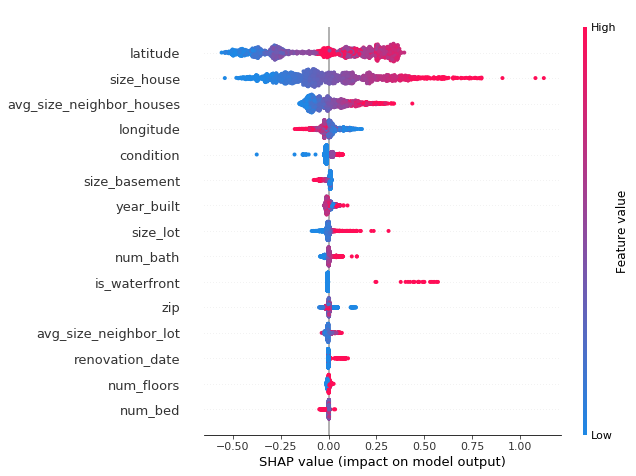

In [48]:
import shap 
shap_values = shap.TreeExplainer(gbr).shap_values(df_test.drop(['price'], axis=1))
shap.summary_plot(shap_values, df_test.drop(['price'], axis=1))

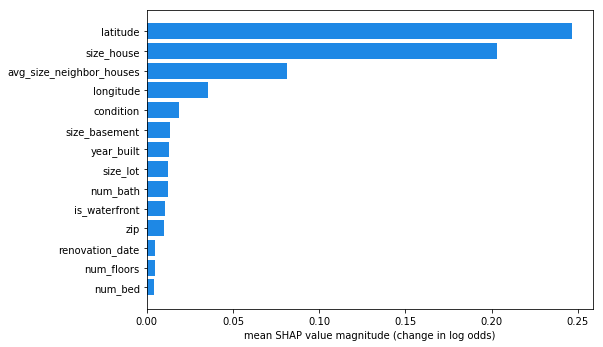

In [50]:
import matplotlib.pyplot as plt

global_shap_vals = np.abs(shap_values).mean(0)[:-1]
variables_values = pd.DataFrame(list(zip(df_test.drop(['price'], axis=1).columns,global_shap_vals)))
variables_values.rename(columns={0:'variable',1:'shap_value'},inplace=True)
variables_values.sort_values(by=['shap_value'],ascending=False,inplace=True)
top_n = variables_values.head(25)

pos=range(0,-top_n.shape[0],-1)
plt.barh(pos, top_n['shap_value'], color="#1E88E5")
plt.yticks(pos, top_n['variable'])
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(8, 5.5)
plt.gca()
plt.show()

2) Agora vamos rodar um GradientBoostingClassifier Faça a mesma comparação utilizando o dataset do titanic, compare a interpretação dos parâmetros de sobrevivência de um GradientBoostingClassifier com uma regressão logistica.


matriz de confusão, f1, precisao, recall, auc

In [51]:
df_t = pd.read_csv('titanic.csv')

In [53]:
list(df_t)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [66]:
y = df_t['Survived']
X = df_t.drop(['Survived'], axis=1)

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

In [68]:
gbc = GradientBoostingClassifier()

In [69]:
X_ = pd.get_dummies(X)
X_ = X_.fillna(0)

In [77]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

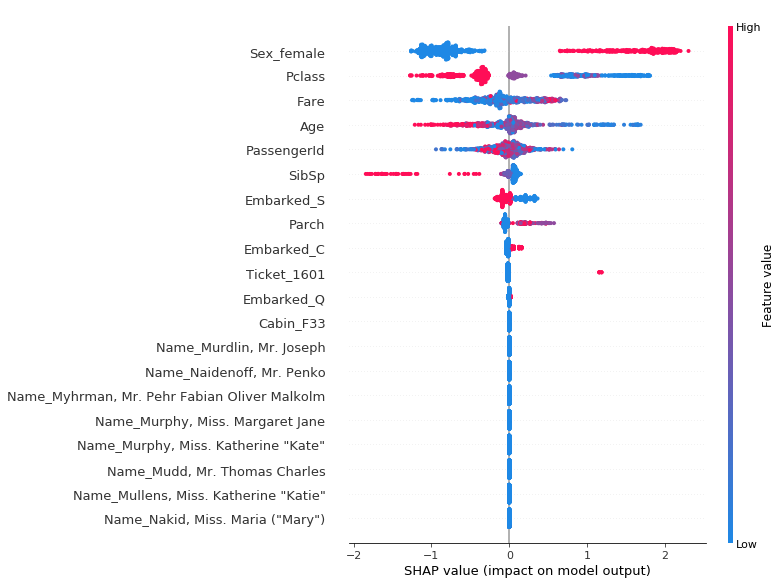

In [117]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_, axis=1)
shap.summary_plot(shap_values, X_)

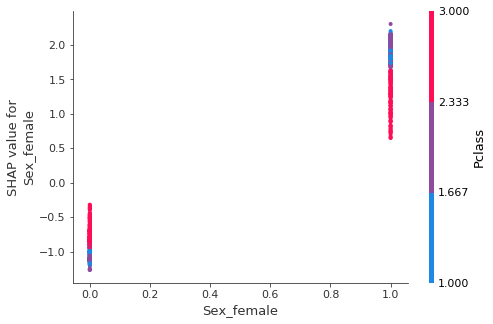

In [120]:
shap.dependence_plot("Sex_female", shap_values, X_)

In [124]:
# demora para rodar.
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_.iloc[200:,])
shap.summary_plot(shap_interaction_values, X_.iloc[200:,])

KeyboardInterrupt: 

In [ ]:
shap.dependence_plot(
    ("Age", "Sex_female"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [81]:
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, auc

In [87]:
import seaborn as sns

In [91]:
yhat = xgb.predict(X_)
yhat_proba = xgb.predict_proba(X_)

In [92]:
import matplotlib.pyplot as plt

In [105]:
def print_metrics(actual, predicted, predicted_proba):
    sns.heatmap(confusion_matrix(actual, predicted),annot=True)
    plt.show()
    print('precisao:', precision_score(actual, predicted))
    print('recall:', recall_score(actual, predicted))
    
    fpr, tpr, _ = roc_curve(y, predicted_proba[:,1])
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

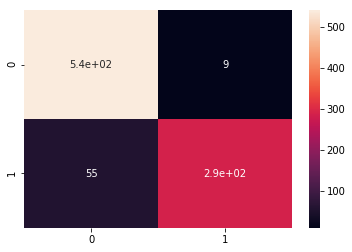

precisao: 0.9695945945945946
recall: 0.8391812865497076


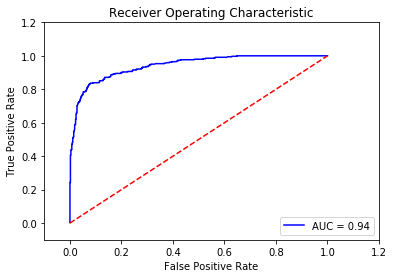

In [106]:
print_metrics(y, yhat, yhat_proba)

In [107]:
from sklearn.linear_model import LogisticRegression

In [108]:
lr = LogisticRegression()

In [109]:
lr.fit(X_, y)
yhat = lr.predict(X_)
yhat_prob = lr.predict_proba(X_)

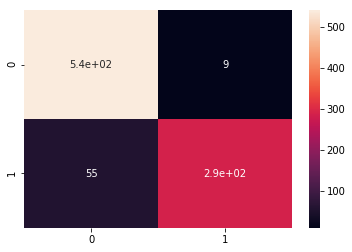

precisao: 0.9695945945945946
recall: 0.8391812865497076


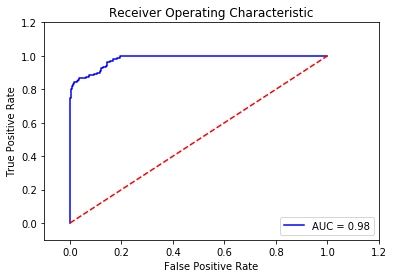

In [111]:
print_metrics(y, yhat, yhat_prob)

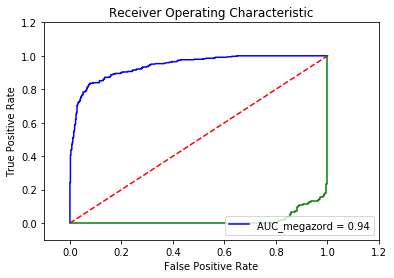

In [116]:
fpr, tpr, _ = roc_curve(y, yhat_proba[:,1])
roc_auc = auc(fpr, tpr)
    
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC_megazord = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

fpr, tpr, _ = roc_curve(y, 1-yhat_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g',label='AUC_logistic = %0.2f'% roc_auc)

plt.show()

### 3 Problema multiclass

https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey

Skyserver_SQL2_27_2018 6_51_39 PM.csv


Nesse mini problema temos um desafio de classificação que chamamos de MULTICLASS, pois ao invés de classificar entre duas classes (que chamamos de classificação binaria, 0/1, temos que classificar entre mais opções).

Nesse problema temos diversas informações sobre "fotografias" do espaço e temos que usar machine learning para classificar se um astro é uma estrela, uma galaxia ou um quasar (maior que uma estrela mas menor que uma galaxia, é o objeto que mais emite radiação no espaço).

Uma regressão logistica não funciona bem nesse caso, pois ao separar classes através de cortes lineares nos dados, ela consegue classificar apenas duas classes (problema binario). Precisamos de algoritmos não paramétricos como knn e métodos de arvores.

Plote as seguintes métricas do seu algoritmo:

matriz de confusão, f1, precisao, recall.

Porque não podemos plotar a AUC simples nesse caso?

# 4 Usar o dataset de fraud (creditcard.csv)

Criar um modelo preditivo que preveja fraude.

A fraude é bastante rara.

Treine o modelo e calcule as métricas:
f1, precisão, recall, auc.

Agora pegue os casos de fraude e repita-os varias vezes (aumente a quantidade de treinamento para casos de fraude) e retreine o modelo.

Por exemplo. Temos 1000 contratos normais e 10 fraudes, repita os contratos de fraude 30 vezes e teremos os mesmos 1000

As métricas mudaram? Pq?

Isso é o inicio da intuição de trabalhar com datasets desbalanceados e repetir a amostra varias vezes é uma tecnica (estupida) de oversampling.

Outra possibilidade é diminuirmos a quantidade de amostras de não fraude para um número mais próximo do número de fraudes, essa técnica chamamos de undersampling.

O que acontece com as métricas?

Vamos usar uma técnica mais avançada agora. Primeiro vamos fazer um oversampling com uma técnica chamada SMOTE do pacote [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn), que é uma extenção do nosso scikit-learn para datasets desbalanceados. Depois de fazer o tal oversampling vamos fazer um undersampling (OVERSAMPLING -> UNDERSAMPLING) e ver o que acontece.